In [1]:
%%time
import os
!pip install torch_snippets pytorch_model_summary
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz
!tar -xf edges2shoes.tar.gz
!rm edges2shoes.tar.gz

     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=7800c3ea4f3150948bc76b049b60ccc83508092b99ef460019c1b32c2ca60f19
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
--2021-01-31 11:20:44--  https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2165283376 (2.0G) [application/x-gzip]
Saving to: ‘edges2shoes.tar.gz’

edges2shoes.tar.gz  100%[===================>]   2.02G  4.53MB/s    in 16m 38s 

2021-01-31 11:37:22 (2.07 MB/s) - ‘edges2shoes.tar.gz’ saved [2165283376/2165283376]

CPU tim

In [3]:
from torch_snippets import *
from pytorch_model_summary import summary
from torchvision import transforms
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f'USING DEVICE: {device}')

IMAGE_SIZE = 256
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# создание датасета
class Pix2PixDataset(Dataset):
    def __init__(self, root):
        self.files = Glob(root, silent=True)
        logger.info(f'Loaded {len(self)} files')
    def __getitem__(self, ix):
        img = cv2.imread(self.files[randint(len(self))])[...,::-1]
        h, w, _ = img.shape
        img_src = Image.fromarray(img[:,:w//2])
        img_trg = Image.fromarray(img[:,w//2:])
        return img_src, img_trg

    # let's restrict to the first few files only
    def __len__(self): return min(10000, len(self.files))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch):
        srcs, trgs = list(zip(*batch))
        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

trn_ds = Pix2PixDataset('edges2shoes/train')
val_ds = Pix2PixDataset('edges2shoes/val')

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True, collate_fn=trn_ds.collate_fn)


2021-01-31 11:49:50.819 | INFO     | __main__:<module>:7 - USING DEVICE: cuda
2021-01-31 11:49:50.928 | INFO     | __main__:__init__:19 - Loaded 10000 files
2021-01-31 11:49:50.931 | INFO     | __main__:__init__:19 - Loaded 200 files


In [4]:
# инициализация весов нормальным распределением
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
# кодирующий блок UNet
class UNetEncoder(nn.Module):
    def __init__(self, in_chan, out, normalize=True, dropout=0.0):
        super(UNetEncoder, self).__init__()
        block = [nn.Conv2d(in_chan, out, 4, 2, 1, bias=False)]
        if normalize:
            block.append(nn.InstanceNorm2d(out))
        block.append(nn.LeakyReLU(0.2))
        if dropout:
            block.append(nn.Dropout(dropout))
        self.encode = nn.Sequential(*block)

    def forward(self, x):
        return self.encode(x)

In [6]:
# декодирующий блок UNet
class UNetDecoder(nn.Module):
    def __init__(self, in_chan, out, normalize=True, dropout=0.0):
        super(UNetDecoder, self).__init__()
        block = [
            nn.ConvTranspose2d(in_chan, out, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out),
            nn.ReLU(inplace=True),
        ]
        if normalize:
            block.append(nn.InstanceNorm2d(out))
        if dropout:
            block.append(nn.Dropout(dropout))
        self.decode = nn.Sequential(*block)

    def forward(self, x, skip_input):
        x = self.decode(x)
        x = torch.cat((x, skip_input), 1)
        return x

In [7]:
# генератор на основе UNet
class GenUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GenUNet, self).__init__()

        # encode слои
        self.encode1 = UNetEncoder(in_channels, 64, normalize=False)
        self.encode2 = UNetEncoder(64, 128)
        self.encode3 = UNetEncoder(128, 256)
        self.encode4 = UNetEncoder(256, 512, dropout=0.5)
        self.encode5 = UNetEncoder(512, 512, dropout=0.5)
        self.encode6 = UNetEncoder(512, 512, dropout=0.5)
        self.encode7 = UNetEncoder(512, 512, dropout=0.5)
        self.encode8 = UNetEncoder(512, 512, normalize=False, dropout=0.5)
        # decode слои
        self.decode1 = UNetDecoder(512, 512, dropout=0.5)
        self.decode2 = UNetDecoder(1024, 512, dropout=0.5)
        self.decode3 = UNetDecoder(1024, 512, dropout=0.5)
        self.decode4 = UNetDecoder(1024, 512, dropout=0.5)
        self.decode5 = UNetDecoder(1024, 256)
        self.decode6 = UNetDecoder(512, 128)
        self.decode7 = UNetDecoder(256, 64)
        #последний слой
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # передача между encode слоями
        d1 = self.encode1(x)
        d2 = self.encode2(d1)
        d3 = self.encode3(d2)
        d4 = self.encode4(d3)
        d5 = self.encode5(d4)
        d6 = self.encode6(d5)
        d7 = self.encode7(d6)
        d8 = self.encode8(d7)
        # skip-connections и передача между decode слоями
        u1 = self.decode1(d8, d7)
        u2 = self.decode2(u1, d6)
        u3 = self.decode3(u2, d5)
        u4 = self.decode4(u3, d4)
        u5 = self.decode5(u4, d3)
        u6 = self.decode6(u5, d2)
        u7 = self.decode7(u6, d1)
        return self.final(u7)

In [8]:
# Дискриминатор
class Disc(nn.Module):
    def __init__(self, in_channels=3):
        super(Disc, self).__init__()

        def detect_layer(in_filt, out_filt, normalization=True):
            layers = [nn.Conv2d(in_filt, out_filt, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filt))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *detect_layer(in_channels * 2, 64, normalization=False),
            *detect_layer(64, 128),
            *detect_layer(128, 256),
            *detect_layer(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [9]:
# настройки сети и обучения
G = GenUNet().to(device)
D = Disc().to(device)
G.apply(weights_init)
D.apply(weights_init)

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

lambda_pixel = 100
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

epochs = 30
log = Report(epochs)

In [14]:
# функции обучения
def d_train(input, true, fake):
    D.train()
    d_optimizer.zero_grad()
    prediction_real = D(true, input)
    error_real = criterion_GAN(prediction_real, torch.ones(len(input), 1, 16, 16).cuda())
    error_real.backward()
    prediction_fake = D(fake.detach(), input)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(input), 1, 16, 16).cuda())
    error_fake.backward()
    d_optimizer.step()
    error_summary = error_real + error_fake
    return error_summary, prediction_real, prediction_fake

def g_train(input, fake):
    D.train()
    g_optimizer.zero_grad()
    prediction = D(fake, input)
    loss_GAN = criterion_GAN(prediction, torch.ones(len(input), 1, 16, 16).cuda())
    loss_pixel = criterion_pixelwise(fake, true)
    loss_summary = loss_GAN + lambda_pixel * loss_pixel
    loss_summary.backward()
    g_optimizer.step()
    return loss_summary

denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))
def sample_prediction():
    """Saves a generated sample from the validation set"""
    data = next(iter(val_dl))
    input, true = data
    fake = G(input)
    img_sample = torch.cat([denorm(input[0]), denorm(fake[0]), denorm(true[0])], -1)
    img_sample = img_sample.detach().cpu().permute(1,2,0).numpy()
    show(img_sample, title='Input, Fake, True', sz=12)

In [ ]:
# обучение 
for epoch in range(epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        input, true = batch
        fake = G(input)
        
        errD, d_loss_real, d_loss_fake = d_train(input, true, fake)
        errG = g_train(input, fake)
        log.record(pos=epoch+(1+bx)/N, errD=errD.item(), errG=errG.item(), 
                   d_loss_real=d_loss_real.mean().item(), d_loss_fake=d_loss_fake.mean().item(), end='\r')

    log.report_avgs(epoch+1)
    [sample_prediction() for _ in range(2)]


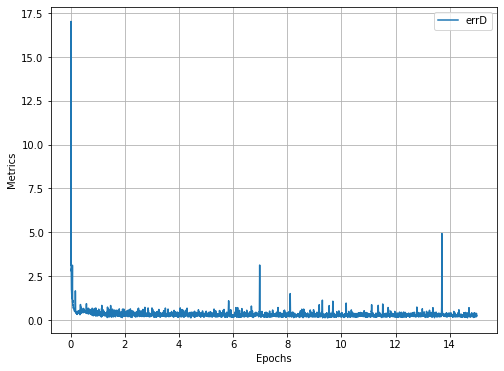

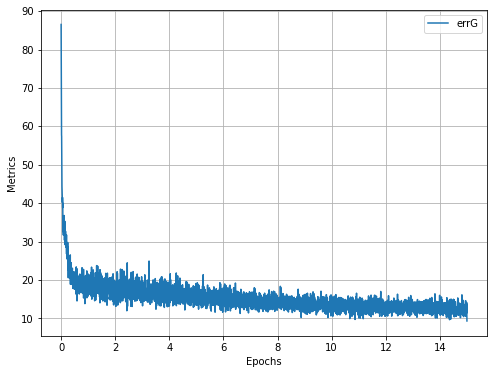

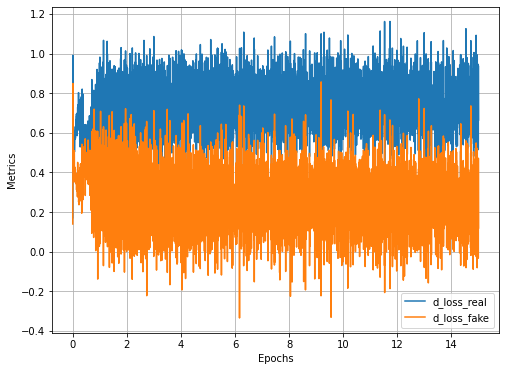

In [12]:
log.plot('errD')
log.plot('errG')
log.plot('d_loss_*')

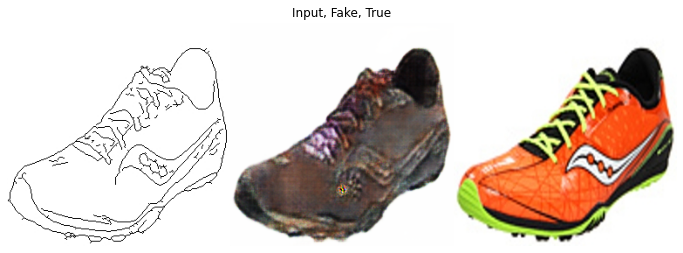

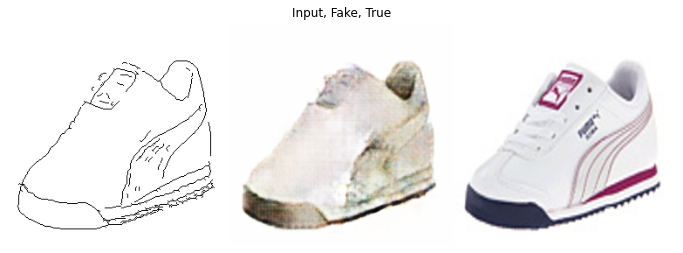

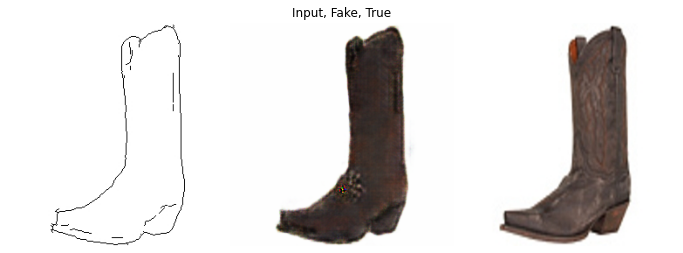

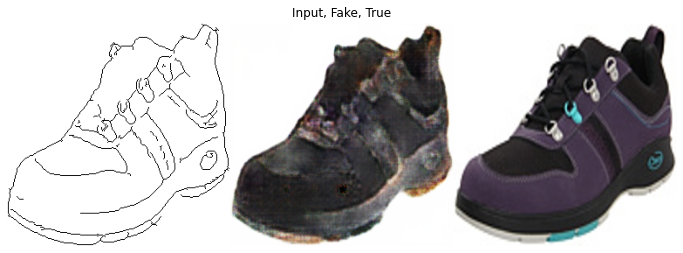

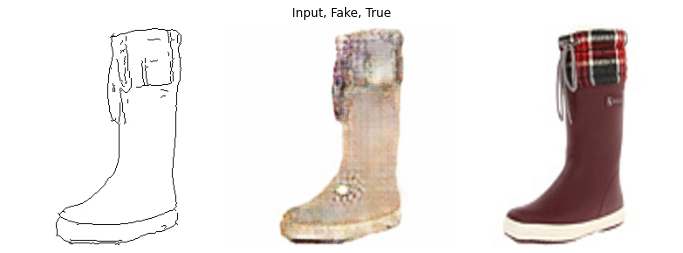

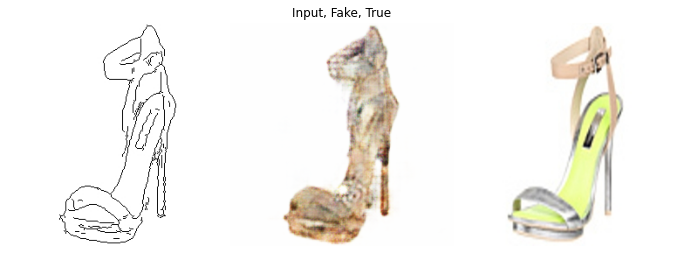

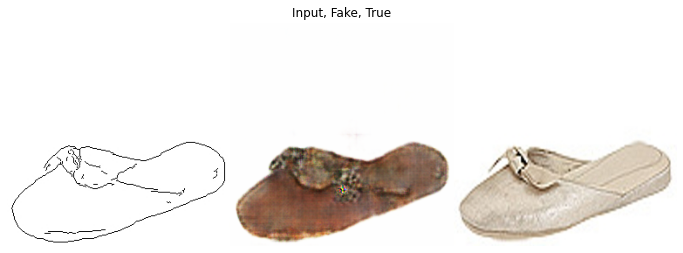

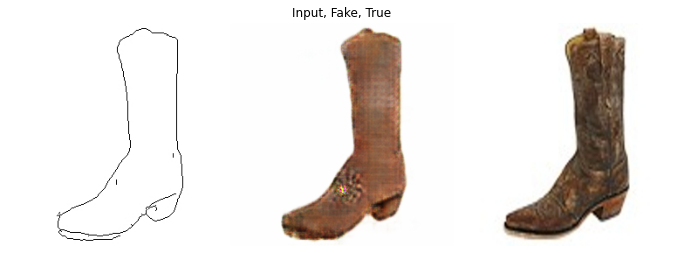

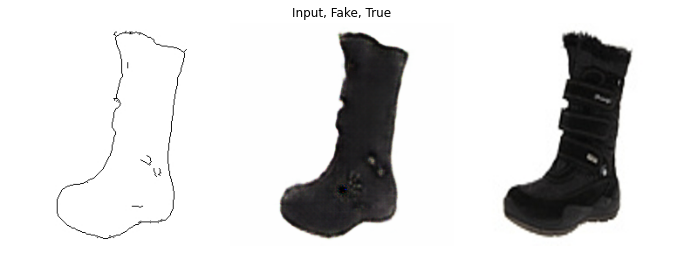

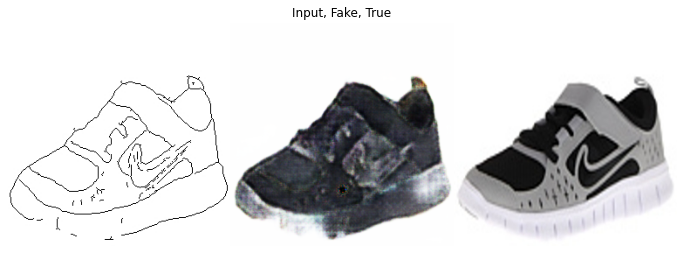

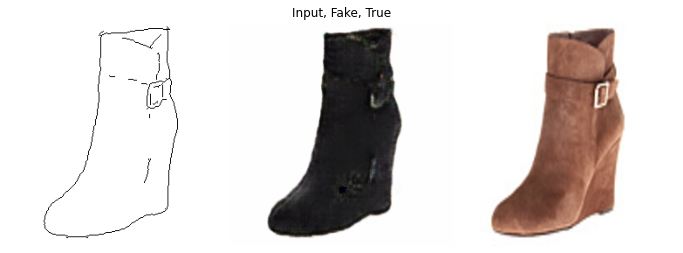

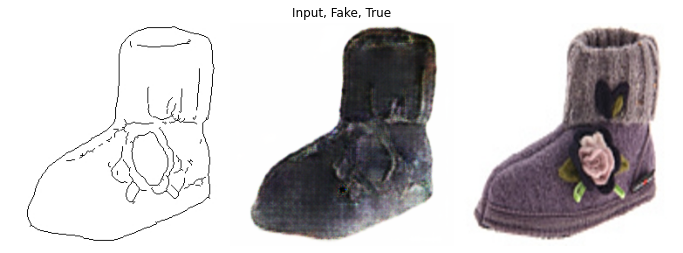

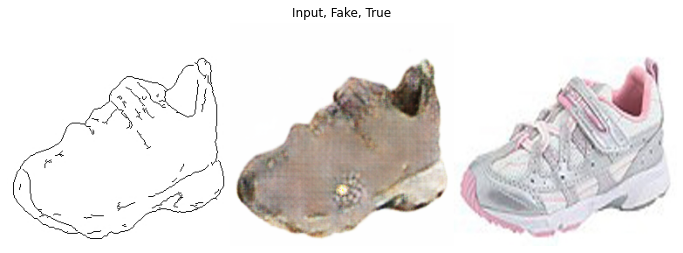

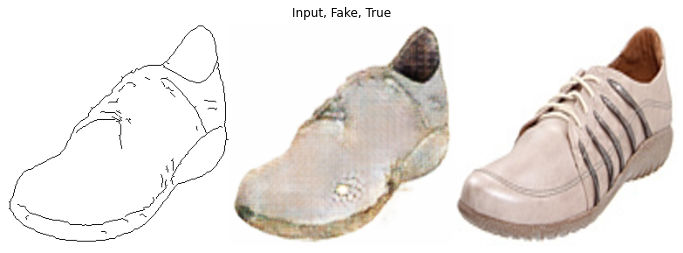

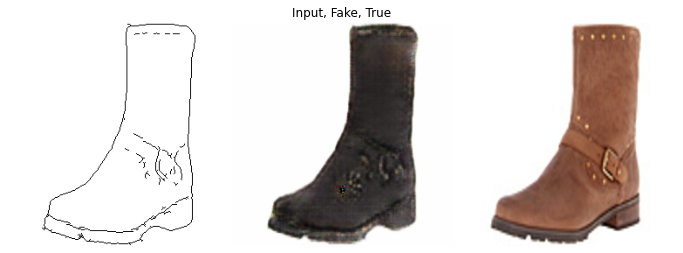

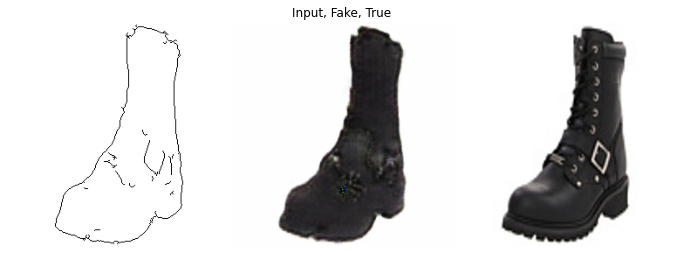

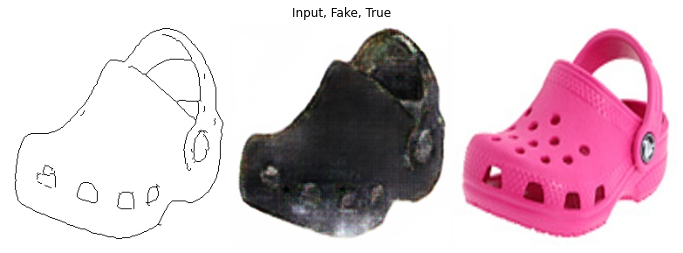

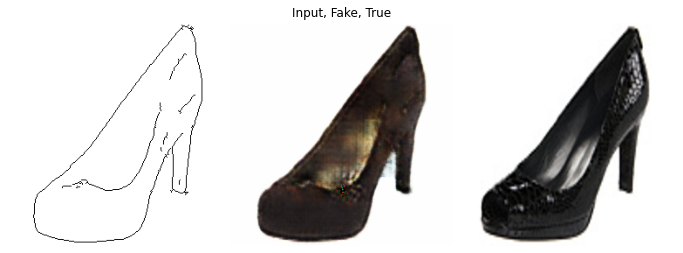

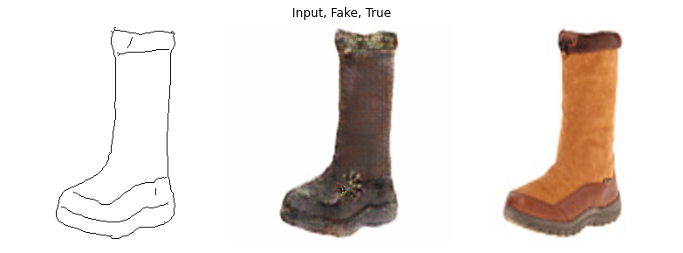

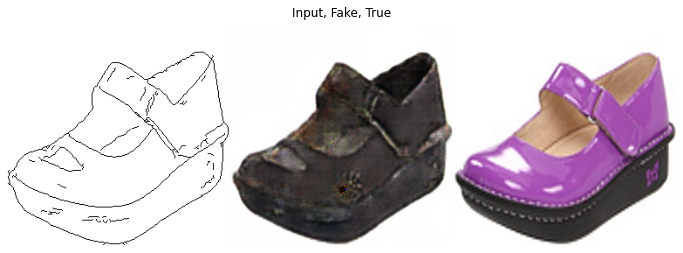

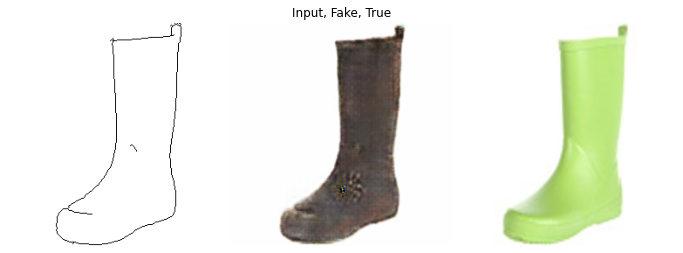

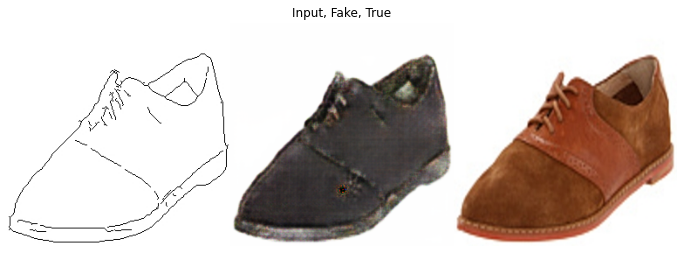

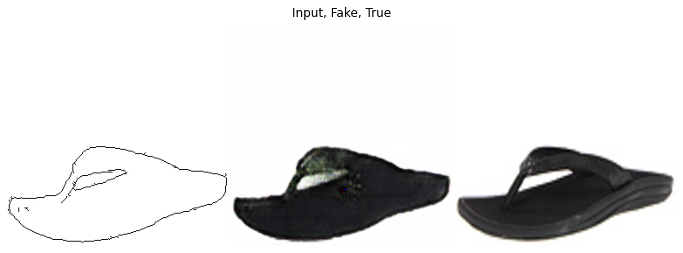

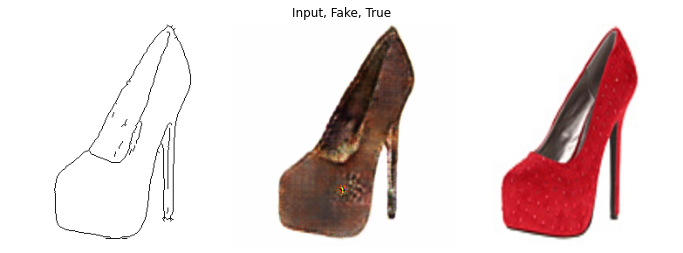

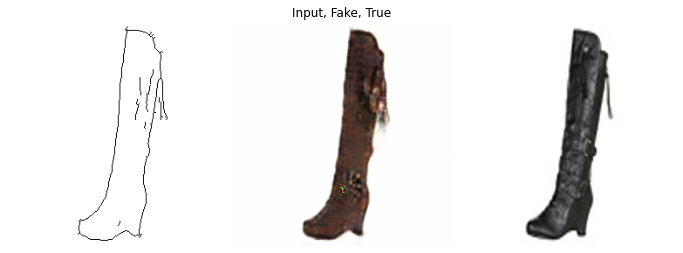

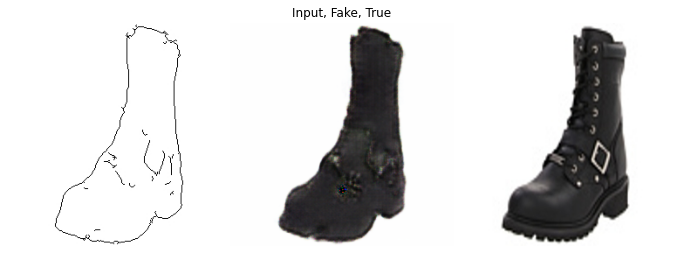

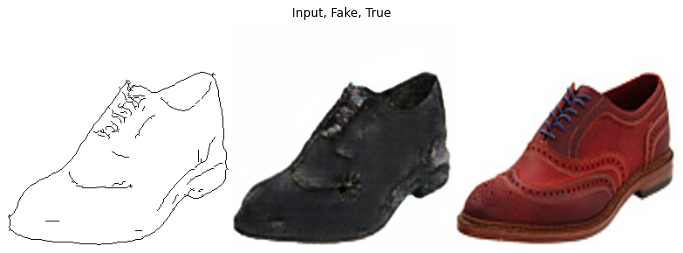

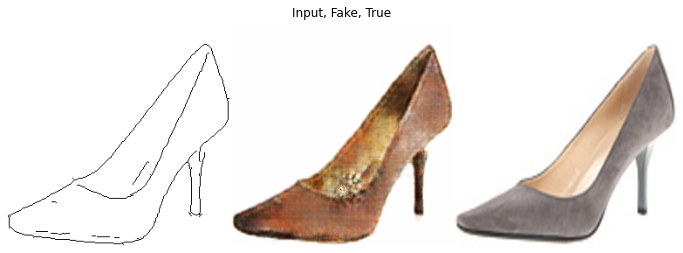

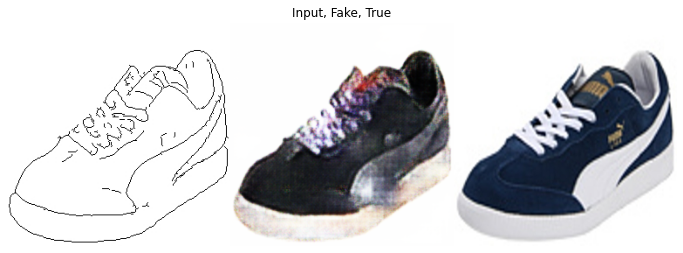

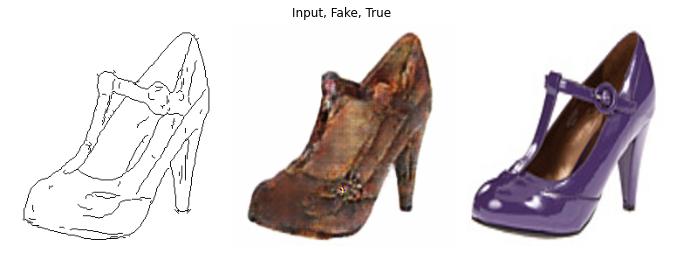

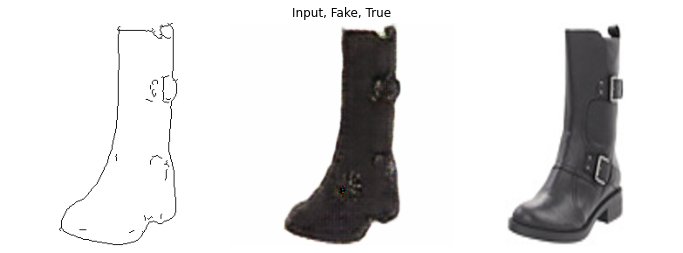

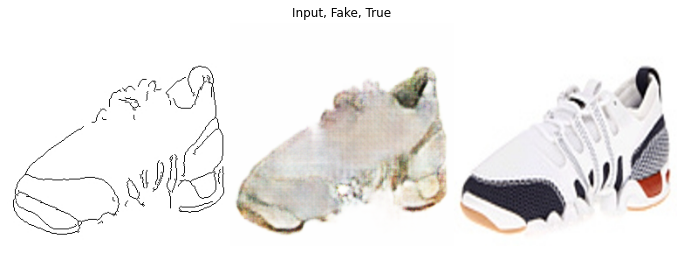

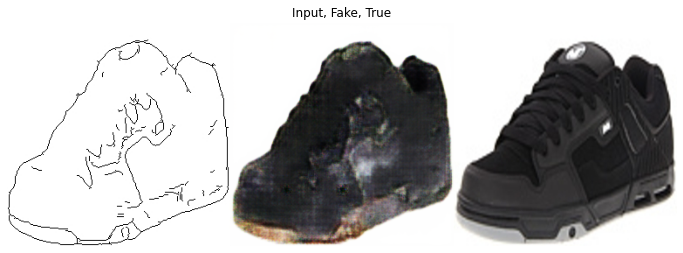

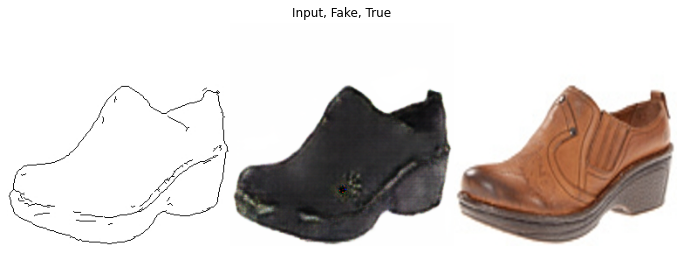

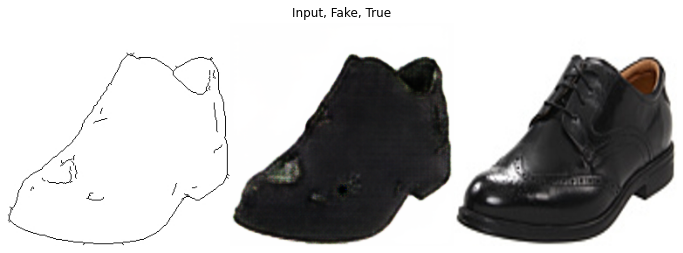

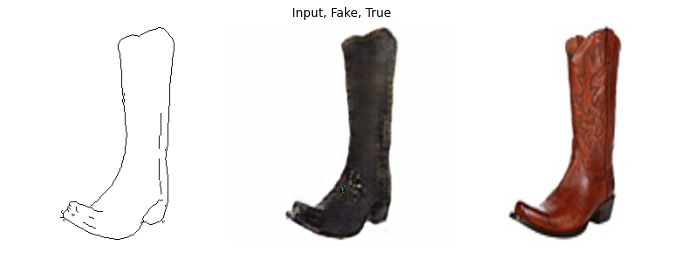

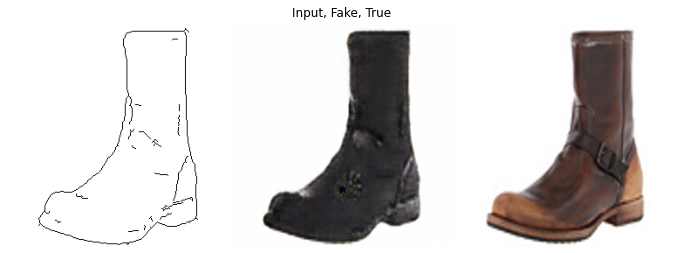

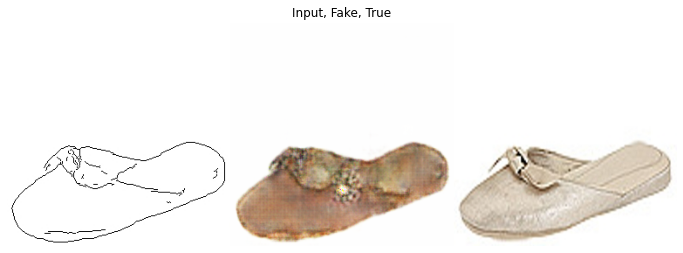

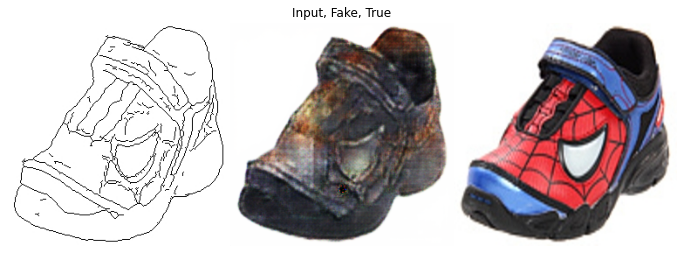

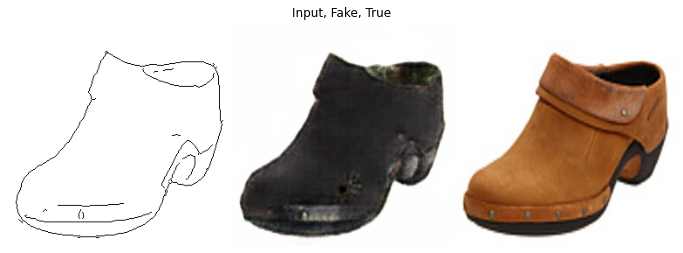

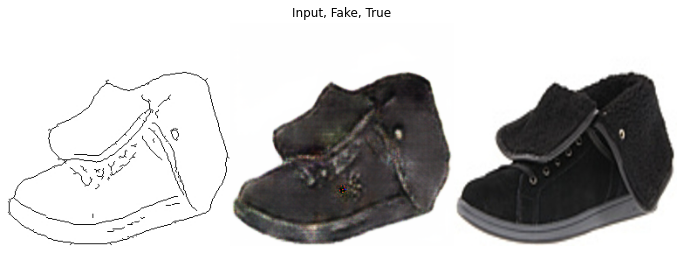

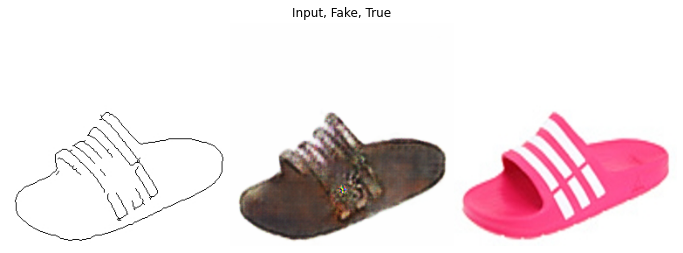

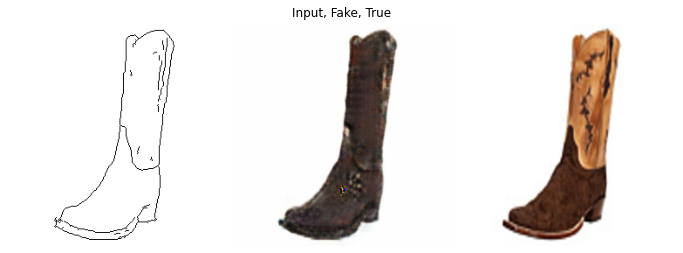

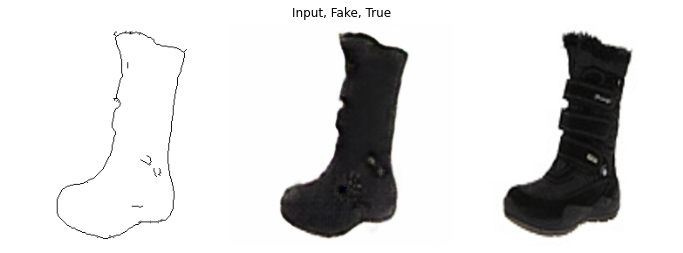

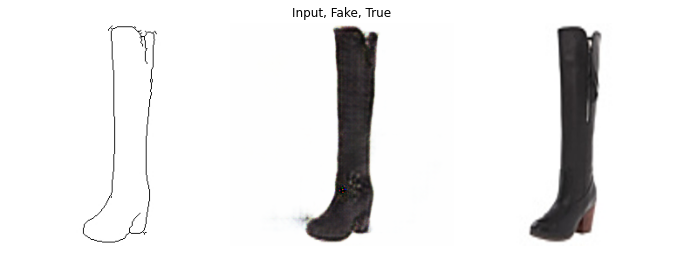

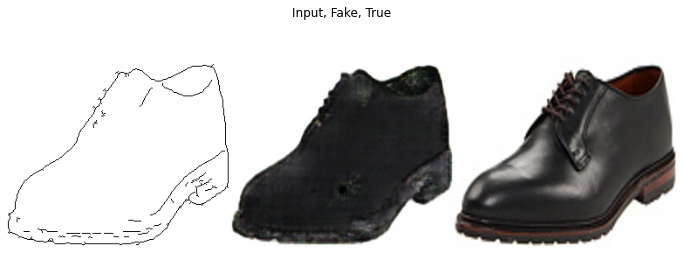

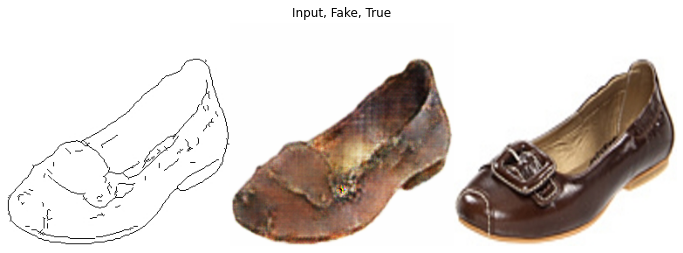

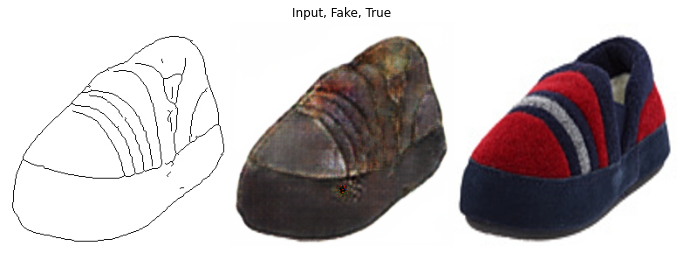

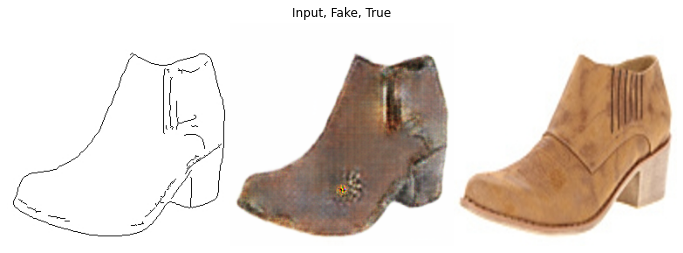

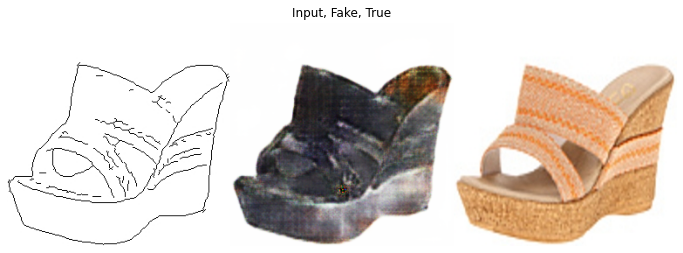

In [15]:
[sample_prediction() for _ in range(50)];